In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import statsmodels.formula.api as smf
import seaborn as sns
import random
from matplotlib.patches import Patch

%matplotlib inline

In [24]:
# Importing the groundwater measurement data in Pickle format
df_ms_ws_input = pd.read_pickle("../data/processed/grundwasserdaten-NRW/GW-MessWasserstellenMerge.pkl")

# Trendanalyse der Grundwasserstände mittels linearer Regression
In dieser Analyse wird der Trend der Grundwasserabsenkung beziehungsweise -anstieg über einen Zeitraum von zehn Jahren (2010–2019) ermittelt. Für jede Messstelle wird die Grundwasserganglinie als Funktion der Zeit (in Tagen) dargestellt. Der betrachtete Zeitraum beginnt am 01.11.2009 und endet am 31.10.2019. Die Wahl des 01. November als Startdatum entspricht dem Beginn des wasserwirtschaftlichen Jahres, also dem Zeitraum, ab dem sich der Grundwasserspiegel in der Regel wieder erneuert.

## Bestimmung der Grundwasser-Trendlinien
In dieser Zelle wird für jede Messstelle eine lineare Trendlinie berechnet, die den langfristigen Anstieg oder Abfall des Grundwasserspiegels beschreibt. Für die einzelnen Messstellen wird zunächst geprüft, ob sie für die Analyse geeignet sind. Um eine belastbare lineare Regression durchführen zu können, werden Messstellen mit weniger als 70 Messpunkten ausgeschlossen. Darüber hinaus werden weitere Ausschlusskriterien definiert:
* Jährliche Änderungen von mehr als 1,5 m/Jahr werden nicht berücksichtigt, da in diesen Fällen von einem starken anthropogenen Einfluss ausgegangen wird.
* Messstellen mit einer Spannweite von mehr als 40 m werden ebenfalls zunächst von der Analyse ausgeschlossen, da auch hier ein dominierender anthropogener Einfluss oder ein technischer Defekt vermutet wird.

In [25]:
mess_id_error = []
mess_id_in = []
mess_id_in_relevant = []
mess_id_in_irrelevant = []
mess_id_out = []

relevant_rows = []
irrelevant_rows = []

# Start of recordings
t0 = pd.Timestamp("2009-11-01")
# In order to have a sufficient data basis, there should be at least 70 measuring points -> empirical values
min_wasserstand_messungen = 70
# With annual changes in the GW level of +/-1.5 m/y, I see a technical influence -> empirical values. 
delta_slope_per_year = 1.5
# If the span is greater than 40 m, there is a technical defect -> empirical values
max_spannweite = 40

groups = df_ms_ws_input.groupby('messstelle_id')

for mess_id in df_ms_ws_input.loc[:, 'messstelle_id'].unique().tolist():

    df_mess_id = groups.get_group(mess_id).sort_values('datum_messung')
    df_mess_id.loc[:, "t"] = (df_mess_id["datum_messung"] - t0).dt.days

    try:
        if len(df_mess_id) > min_wasserstand_messungen:
            mess_id_in.append(mess_id)

            # Linear regression
            model_wasserstd_t = smf.ols(formula='wasserstd_m ~ t', data=df_mess_id)
            results = model_wasserstd_t.fit()
               
            messstelle = {
                'messstelle_id': mess_id,
                'slope_m_yr': results.params["t"] * 365.25,
                'intercept_m': results.params["Intercept"],
                'drawdown': False,
                'minimum_m': df_mess_id.loc[:, 'wasserstd_m'].min(),
                'maximum_m': df_mess_id.loc[:, 'wasserstd_m'].max(),
                'range_m': 0.0,
                'count_messpunkte': len(df_mess_id),
            }

            if messstelle['slope_m_yr'] >= 0:
                messstelle['drawdown'] = False
            else:
                messstelle['drawdown'] = True
            
            messstelle['range_m'] = messstelle['maximum_m'] - messstelle['minimum_m']

            # Exclusion of outliers and extreme values
            if abs(messstelle['slope_m_yr']) <= delta_slope_per_year and messstelle['range_m'] < max_spannweite:
                mess_id_in_relevant.append(mess_id)
                relevant_rows.append(messstelle)
            else:
                mess_id_in_irrelevant.append(mess_id)
                irrelevant_rows.append(messstelle)
        else:
            mess_id_out.append(mess_id)
    except Exception:
        mess_id_error.append(mess_id)

if len(mess_id_error) > 0:
    print(f'Anzahl Fehler: {len(mess_id_error)}')
    print(mess_id_error)

df_mess_id_relevant = pd.DataFrame(relevant_rows)
df_mess_id_irrelevant = pd.DataFrame(irrelevant_rows)


## Absolute und relative Kenngrößen
Ableitung absoluter und relativer Kennwerte zur quantitativen Beschreibung der Grundwasserentwicklung.

In [26]:
total_messstellen = len(mess_id_in) + len(mess_id_out)
print(f'Gesamtanzahl der Grundwasser-Messstellen: {total_messstellen}')
print('------------------------------------------')
print(f'Grenze der Mindestanzahl an Messpunkten: {min_wasserstand_messungen}')
print(f'\tinnerhalb: {len(mess_id_in)}  -> {len(mess_id_in)/total_messstellen*100:.1f}%')
print(f'\taußerhalb: {len(mess_id_out)}  -> {len(mess_id_out)/total_messstellen*100:.1f}%\n')
print(f'Nähere Betrachtung der {len(mess_id_in)} interessanten Messtellen')
print(f'\tbetrachteter Antieg max. +/-{delta_slope_per_year}m pro Jahr')
print(f'\tbetrachtete Spannweite max. {max_spannweite}m')
print(f'\t\tinnerhalb: {len(mess_id_in_relevant)}'
      f'  -> {len(mess_id_in_relevant)/len(mess_id_in)*100:.1f}%')
print(f'\t\taußerhalb: {len(mess_id_in_irrelevant)}'
      f'  -> {len(mess_id_in_irrelevant)/len(mess_id_in)*100:.1f}%\n')
print(f'Resultierend zu analaysierende Messstellen: {len(mess_id_in_relevant)}'
      f'  -> {len(mess_id_in_relevant)/total_messstellen*100:.1f}% (von {total_messstellen})')
print(f'\tSenkung GW-Pegel: {(df_mess_id_relevant["drawdown"] == 1).sum()}'
      f'  -> {(df_mess_id_relevant["drawdown"] == 1).sum()/len(df_mess_id_relevant)*100:.1f}%')
print(f'\tAnstieg GW-Pegel: {(df_mess_id_relevant["drawdown"] == 0).sum()}'
      f'  -> {(df_mess_id_relevant["drawdown"] == 0).sum()/len(df_mess_id_relevant)*100:.1f}%')


Gesamtanzahl der Grundwasser-Messstellen: 11348
------------------------------------------
Grenze der Mindestanzahl an Messpunkten: 70
	innerhalb: 10036  -> 88.4%
	außerhalb: 1312  -> 11.6%

Nähere Betrachtung der 10036 interessanten Messtellen
	betrachteter Antieg max. +/-1.5m pro Jahr
	betrachtete Spannweite max. 40m
		innerhalb: 9958  -> 99.2%
		außerhalb: 78  -> 0.8%

Resultierend zu analaysierende Messstellen: 9958  -> 87.8% (von 11348)
	Senkung GW-Pegel: 8409  -> 84.4%
	Anstieg GW-Pegel: 1549  -> 15.6%


In [27]:
df_mess_id_relevant.head()

,messstelle_id,slope_m_yr,intercept_m,drawdown,minimum_m,maximum_m,range_m,count_messpunkte
0,070283916,0.067013,157.766118,False,157.389999,159.130005,1.740005,137
1,010445730,-0.179650,31.210349,True,26.799999,30.820000,4.020000,2250
2,010445791,-0.062256,31.152236,True,30.170000,31.610001,1.440001,2207
3,010446722,0.075724,80.778631,False,80.760002,81.589996,0.829994,1705
4,100151115,0.015632,39.662841,False,38.310001,40.500000,2.189999,120


In [28]:
df_mess_id_relevant.describe()

,slope_m_yr,intercept_m,minimum_m,maximum_m,range_m,count_messpunkte
count,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000
mean,-0.047457,71.616232,70.109145,72.903296,2.794150,379.649930
std,0.125455,58.078130,57.770015,58.607944,3.188889,734.959361
min,-1.488518,-176.766913,-179.869995,-176.559998,0.020000,71.000000
25%,-0.069720,38.014681,36.822500,39.172499,1.320000,114.000000
50%,-0.036857,50.188308,48.809999,51.350000,1.870003,120.000000
75%,-0.012305,89.492341,88.650002,90.737499,3.020004,176.000000
max,1.478314,538.288422,536.640015,541.390015,39.389999,3652.000000


## Visualisierung der Ganglinien zufällig ausgewählter relevanter und irrelevanter Messstellen
In der folgenden Zelle werden die Grundwasserganglinien von jeweils zwei zufällig ausgewählten Messstellen dargestellt. Dies ermöglicht einen anschaulichen Überblick über die unterschiedlichen Messstellen und deren zeitliche Entwicklung. Als irrelevante Messstellen gelten dabei jene, die die zuvor definierten Ausschlusskriterien nicht erfüllen. Relevante Messstellen sind entsprechend diejenigen, die für die weitere Analyse herangezogen werden.

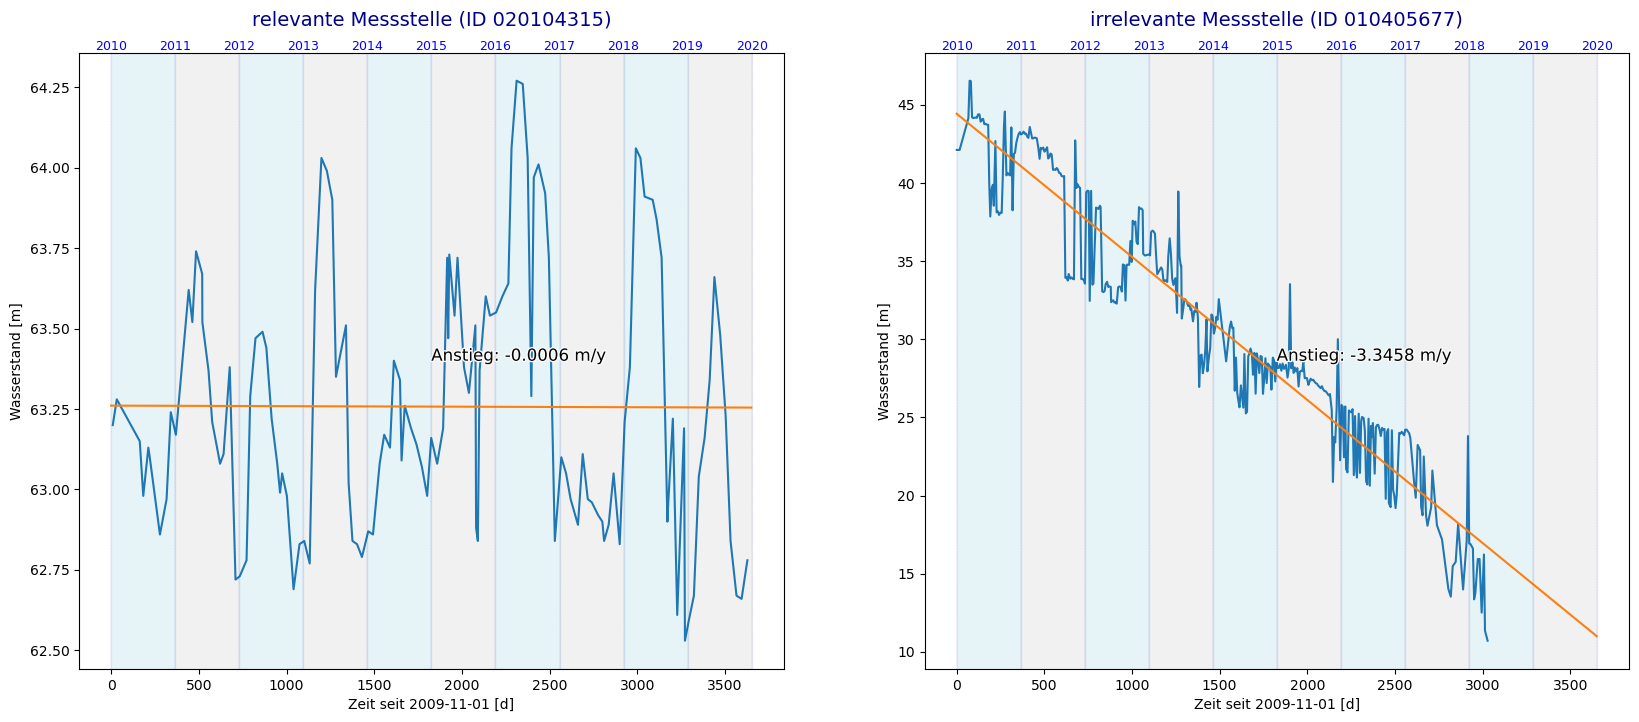

In [29]:
# start date
tage_pro_jahr = 365.25 # With leap year
startjahr = 2010 # Calendar date
t0 = pd.Timestamp("2009-11-01") # Start of the 2010 water management year

random_relevant_ms = random.choice(mess_id_in_relevant)
random_irrelevant_ms = random.choice(mess_id_in_irrelevant)

df_relevant_ms = (
        df_ms_ws_input
        .loc[df_ms_ws_input.loc[:, 'messstelle_id'] == random_relevant_ms]
        .sort_values('datum_messung')
        .copy()
        )

df_irrelevant_ms = (
        df_ms_ws_input
        .loc[df_ms_ws_input.loc[:, 'messstelle_id'] == random_irrelevant_ms]
        .sort_values('datum_messung')
        .copy()
        )

df_relevant_ms["t"] = (df_relevant_ms["datum_messung"] - t0).dt.days
df_irrelevant_ms["t"] = (df_irrelevant_ms["datum_messung"] - t0).dt.days

# Linear regression
model_relevant_ms = smf.ols(formula='wasserstd_m ~ t', data=df_relevant_ms)
results_relevant_ms = model_relevant_ms.fit()

model_irrelevant_ms = smf.ols(formula='wasserstd_m ~ t', data=df_irrelevant_ms)
results_irrelevant_ms = model_irrelevant_ms.fit()

# Plotting randomly selected groundwater measuring points
fig, ax = plt.subplots(figsize=[20, 8], nrows=1, ncols=2)

# regression lines
df_relevant_ms.plot(kind='line', x='t', y='wasserstd_m', ax=ax[0], legend=False)
df_irrelevant_ms.plot(kind='line', x='t', y='wasserstd_m', ax=ax[1], legend=False)

(results_relevant_ms.predict(pd.DataFrame({"t": range(3651)}))).plot(ax=ax[0])
(results_irrelevant_ms.predict(pd.DataFrame({"t": range(3651)}))).plot(ax=ax[1])

ax[0].set_title(f"relevante Messstelle (ID {random_relevant_ms})", fontsize=14, color="darkblue", pad=20)
ax[1].set_title(f"irrelevante Messstelle (ID {random_irrelevant_ms})", fontsize=14, color="darkblue", pad=20)
ax[0].set_xlabel(f"Zeit seit {t0.strftime("%Y-%m-%d")} [d]")
ax[1].set_xlabel(f"Zeit seit {t0.strftime("%Y-%m-%d")} [d]")
ax[0].set_ylabel("Wasserstand [m]")
ax[1].set_ylabel("Wasserstand [m]")

ax[0].text(x=sum(ax[0].get_xlim()) / 2, y=sum(ax[0].get_ylim()) / 2,
           s=f"Anstieg: {results_relevant_ms.params["t"] * 365.25:.4f} m/y",
           path_effects=[path_effects.Stroke(linewidth=2, foreground='#FAFAFA'), path_effects.Normal()],
           fontsize=12)
ax[1].text(x=sum(ax[1].get_xlim()) / 2, y=sum(ax[1].get_ylim()) / 2,
           s=f"Anstieg: {results_irrelevant_ms.params["t"] * 365.25:.4f} m/y",
           path_effects=[path_effects.Stroke(linewidth=2, foreground='#FAFAFA'), path_effects.Normal()],
           fontsize=12)

for axes in range(2):
    for jahr in range(10):
        start = jahr * tage_pro_jahr
        ende = (jahr + 1) * tage_pro_jahr

        ax[axes].axvspan(start, ende, 
                color=("lightblue" if jahr % 2 == 0 else "lightgray"),
                alpha=0.3)

    for jahr in range(11):   # 10 years = 11 stamps
        x_pos = jahr * tage_pro_jahr
        ax[axes].axvline(x=x_pos, color="blue", linestyle=":", alpha=0.7, linewidth=0.2)
        ax[axes].text(
            x_pos,         
            ax[axes].get_ylim()[1],
            str(startjahr + jahr),
            ha="center", va="bottom",
            fontsize=9, color="blue"
        )


In [30]:
df_irrelevant_ms.head(3)

,messstelle_id,name,e32,n32,turnus_wasserstand,freigabe_wstd,freigabe_chemie,freigabe_lage,messstellenart,datum_messung,abstich_m,hinweis,wasserstd_m,flurabstd_m,mph_m,gok_m,wwj,t
1907907,010405677,WGA HOLZWEIL.BR.606,319150,5660350,wöchentlich,ja,nein,nein,GW-Messstelle,2009-11-02,44.450001,-,42.119999,46.209999,86.57,88.330002,2010,1
1907908,010405677,WGA HOLZWEIL.BR.606,319150,5660350,wöchentlich,ja,nein,nein,GW-Messstelle,2009-11-18,44.450001,-,42.119999,46.209999,86.57,88.330002,2010,17
1907909,010405677,WGA HOLZWEIL.BR.606,319150,5660350,wöchentlich,ja,nein,nein,GW-Messstelle,2010-01-07,42.419998,-,44.150002,44.180000,86.57,88.330002,2010,67


<Axes: >

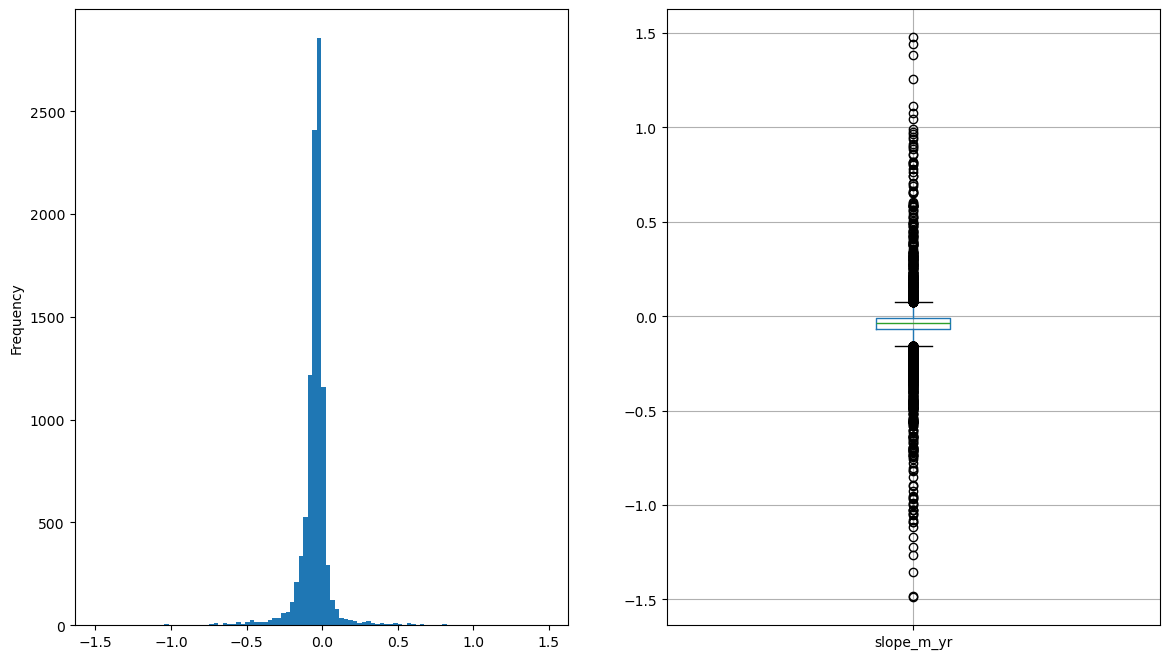

In [31]:
fig, ax = plt.subplots(figsize=[14, 8], nrows=1, ncols=2)

df_mess_id_relevant['slope_m_yr'].plot(kind='hist', bins=100, ax=ax[0])

df_mess_id_relevant.boxplot(
    column="slope_m_yr",
    # by="senkung",
    grid=True,
    ax=ax[1]
)

## Statistik des Grundwasseranstieges


In [32]:
df_mess_id_relevant["slope_m_yr"].describe()

count    9958.000000
mean       -0.047457
std         0.125455
min        -1.488518
25%        -0.069720
50%        -0.036857
75%        -0.012305
max         1.478314
Name: slope_m_yr, dtype: float64

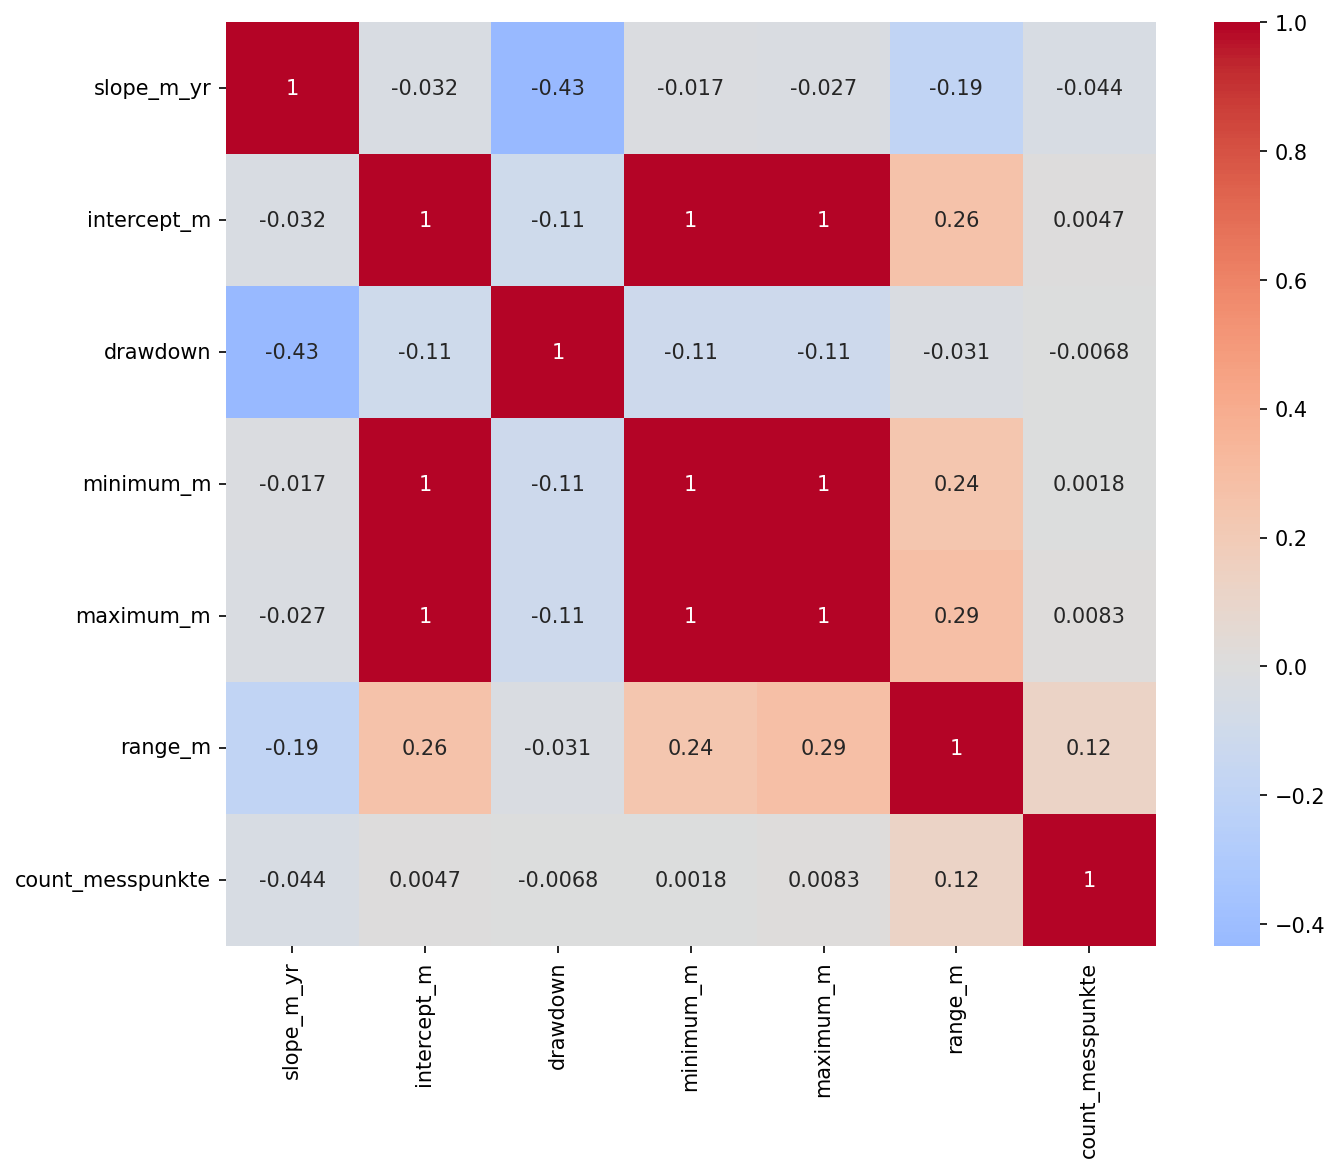

In [33]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=150)

sns.heatmap(df_mess_id_relevant.corr(numeric_only=True), annot=True, cmap="coolwarm", center=0, ax=ax);

## Häufigkeitsverteilung der Trendklassen der jährlichen Grundwasseränderung
In den nachfolgenden Zellen werden die jährlichen Grundwasseränderungen in fünf Klassen eingeteilt und deren jeweilige Häufigkeiten ermittelt. Anschließend werden die absoluten und relativen Klassenhäufigkeiten in einem Balkendiagramm dargestellt, anhand dessen sich der globale Trend der Grundwasserentwicklung gut ablesen lässt.

In [34]:
df_mess_id_relevant["slope_m_yr_class"] = pd.cut(
    df_mess_id_relevant["slope_m_yr"],
    bins=[-1.5, -0.5, -0.1, 0.1, 0.5, 1.5],
    labels=[1, 2, 3, 4, 5],
    include_lowest=True
)

In [35]:
df_mess_id_relevant.head()

,messstelle_id,slope_m_yr,intercept_m,drawdown,minimum_m,maximum_m,range_m,count_messpunkte,slope_m_yr_class
0,070283916,0.067013,157.766118,False,157.389999,159.130005,1.740005,137,3
1,010445730,-0.179650,31.210349,True,26.799999,30.820000,4.020000,2250,2
2,010445791,-0.062256,31.152236,True,30.170000,31.610001,1.440001,2207,3
3,010446722,0.075724,80.778631,False,80.760002,81.589996,0.829994,1705,3
4,100151115,0.015632,39.662841,False,38.310001,40.500000,2.189999,120,3


In [36]:
print(df_mess_id_relevant["slope_m_yr_class"].value_counts(normalize=False).sort_index())
print(df_mess_id_relevant["slope_m_yr_class"].value_counts(normalize=True).mul(100).sort_index())

slope_m_yr_class
1      92
2    1361
3    8226
4     227
5      52
Name: count, dtype: int64
slope_m_yr_class
1     0.923880
2    13.667403
3    82.606949
4     2.279574
5     0.522193
Name: proportion, dtype: float64


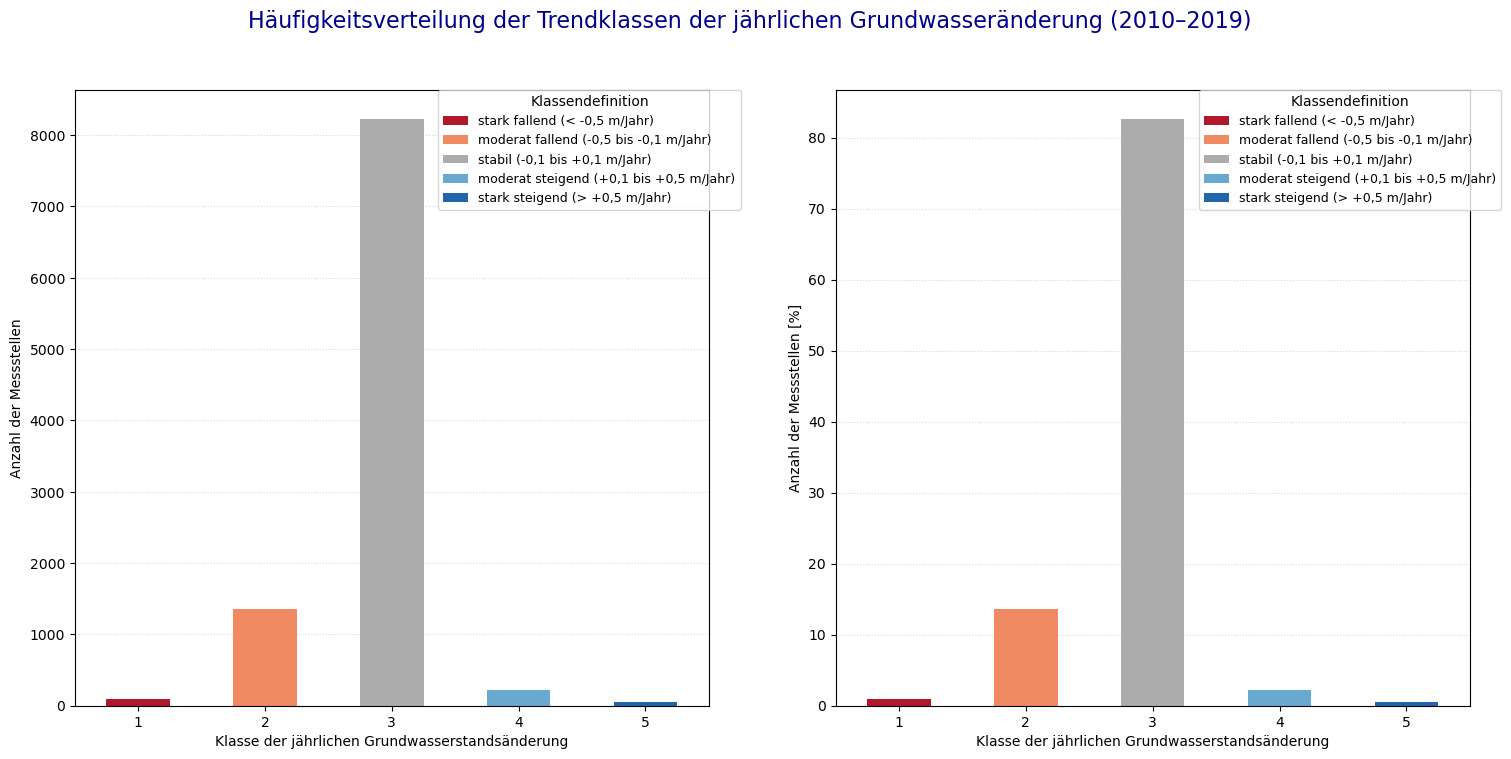

In [42]:
fig, ax = plt.subplots(figsize=[18, 8], nrows=1, ncols=2)

color_classes = {
    1: {"farbe": "#b2182b", "label": "stark fallend (< -0,5 m/Jahr)"},
    2: {"farbe": "#ef8a62", "label": "moderat fallend (-0,5 bis -0,1 m/Jahr)"},
    3: {"farbe": "#a7a7a7ef", "label": "stabil (-0,1 bis +0,1 m/Jahr)"},
    4: {"farbe": "#67a9cf", "label": "moderat steigend (+0,1 bis +0,5 m/Jahr)"},
    5: {"farbe": "#2166ac", "label": "stark steigend (> +0,5 m/Jahr)"}
}

counts = (
    df_mess_id_relevant["slope_m_yr_class"]
    .astype("Int64")
    .value_counts()
    .reindex(color_classes.keys(), fill_value=0)
)

color_list = [color_classes[k]["farbe"] for k in counts.index]

(
    df_mess_id_relevant.loc[:,'slope_m_yr_class']
    .value_counts(normalize=False)
    .sort_index()
    .plot(kind='bar', ax=ax[0], color=color_list)
    )
(
    df_mess_id_relevant.loc[:,'slope_m_yr_class']
    .value_counts(normalize=True)
    .sort_index()
    .mul(100)
    .plot(kind='bar', ax=ax[1], color=color_list)
    )

for axes in range(2):

    handles = [
    Patch(
        facecolor=patch.get_facecolor(),
        label=color_classes[i]['label']
    )
    for i, patch in zip(counts.index, ax[axes].patches)
    ]
    
    ax[axes].grid(True, linestyle=':', alpha=0.5, axis='y')
    ax[axes].set_axisbelow(True)
    ax[axes].set_xlabel('Klasse der jährlichen Grundwasserstandsänderung', fontsize=10)
    ax[axes].set_xticklabels(['1', '2', '3', '4', '5'], rotation=0)
    
    if axes == 0:
        ax[axes].set_ylabel('Anzahl der Messstellen', fontsize=10)
    if axes == 1:
        ax[axes].set_ylabel('Anzahl der Messstellen [%]', fontsize=10)

    ax[axes].legend(
        handles=handles,
        title="Klassendefinition",
        loc="upper right",
        fontsize=9,
        bbox_to_anchor=(1.05, 1),
        borderaxespad=0
    )

fig.set_tight_layout
fig.suptitle('Häufigkeitsverteilung der Trendklassen der jährlichen Grundwasseränderung (2010–2019)',
             fontsize=16, color="darkblue");

In [38]:
counts

slope_m_yr_class
1      92
2    1361
3    8226
4     227
5      52
Name: count, dtype: Int64

## Export und Aufbereitung der Ergebnisse für QGIS
Die Analyse der jährlichen Grundwasseränderungen erfolgte zunächst für jede Messstelle separat. Zwar lässt sich mithilfe der Klassifizierung ein globaler Trend ableiten, die Zusammenhänge zwischen den Messstellen sind jedoch räumlicher Natur. In den folgenden Zellen werden die aufbereiteten Daten für Geoinformationssysteme wie QGIS exportiert. Dies ermöglicht eine räumliche Analyse und den direkten Vergleich der Grundwassermessstellen untereinander.

In [39]:
# Importing groundwater measurement points in Pickle format
df_ms = pd.read_pickle("../data/processed/grundwasserdaten-NRW/GW-Messstellen.pkl")

df_ms_ws_gis = pd.merge(
    df_ms,
    df_mess_id_relevant,
    on="messstelle_id",
    how="inner"
)

df_ms_ws_gis.head()

,messstelle_id,name,e32,n32,turnus_wasserstand,freigabe_wstd,freigabe_chemie,freigabe_lage,messstellenart,slope_m_yr,intercept_m,drawdown,minimum_m,maximum_m,range_m,count_messpunkte,slope_m_yr_class
0,070283916,LGD BN KOTTENF. 3,362354,5615873,monatlich,ja,ja,ja,GW-Messstelle,0.067013,157.766118,False,157.389999,159.130005,1.740005,137,3
1,010445730,60BP010505,291150,5669250,vierzehntäglich,ja,nein,nein,GW-Messstelle,-0.179650,31.210349,True,26.799999,30.820000,4.020000,2250,2
2,010445791,60BP010701,290850,5665750,vierzehntäglich,ja,nein,nein,GW-Messstelle,-0.062256,31.152236,True,30.170000,31.610001,1.440001,2207,3
3,010446722,60GP012301,292050,5645350,monatlich,ja,nein,nein,GW-Messstelle,0.075724,80.778631,False,80.760002,81.589996,0.829994,1705,3
4,100151115,WE 33 WEHE,478750,5808550,monatlich,ja,nein,nein,GW-Messstelle,0.015632,39.662841,False,38.310001,40.500000,2.189999,120,3


In [40]:
df_ms_ws_gis.shape

(9958, 17)

In [41]:
# Export DataFrame to CSV and Pickle
df_ms_ws_gis.to_csv("../data/processed/grundwasserdaten-NRW/GW-MessstellenSlopePerYearGIS.csv", float_format="%.3f")
df_ms_ws_gis.to_pickle("../data/processed/grundwasserdaten-NRW/GW-MessstellenSlopePerYearGIS.pkl")